In [26]:
import os
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import LabelEncoder

#### 这是第一个函数 用于获取`source_string`和`target_string`两个列表。     
这两个列表的数据为:    
    每个文件里面的词按空格分隔后，组成的列表；然后每个列表在组成的列表，这个列表的长度为8

In [27]:
# 通过文件夹名获取两个列表，中的数据为
def get_train_list(source_folder, target_folder):
    source_string = []
    target_string = []
    # os.listdir 用于返回指定的文件夹包含的文件或文件夹的名字的 列表
    for filename in os.listdir(source_folder):
        # 把未标注文本的文件名拼接为和目标文本一样的文件名
        target_file_name = "targetH_" + "_".join(filename.split("_")[1:])
        # os.path.exists 如果path存在，返回True；如果path不存在，返回False。 
        # os.path.join 用于拼接文件路径
        # 检查 拼好的这个文件名在目标文件里是否存在
        if os.path.exists(os.path.join(target_folder, target_file_name)):
            # 打开 源文件 和 目标文件
            with open(os.path.join(source_folder, filename), 'r', encoding="utf-8") as source:
                with open(os.path.join(target_folder, target_file_name), 'r', encoding="utf-8") as target:
                    # zip 返回 两个参数对应位置拼成一个元组 的一个由元组组成的列表
                    # 这里用zip我认为就是为了把两个内容写进一个for里 方便比较
                    for source_line, target_line in zip(source.readlines(), target.readlines()):  
                        s_line = source_line.split() # source_line 是一个str，按空格分割一下
                        t_line = target_line.split()
                        # 如果长度相等代表标注正确 
                        if len(s_line) == len(t_line):
                            source_string.append(s_line)
                            target_string.append(t_line)
    print('源数据读取完毕，共' + str(len(source_string)) + '行')
    return source_string, target_string

In [28]:
source_folder = 'data_命名实体抽取/split'
target_folder = 'data_命名实体抽取/targetH'
splitList = os.listdir(source_folder)
splitList
filename = splitList[0]
target_file_name = "targetH_" + "_".join(filename.split("_")[1:])

jointPath = os.path.join(source_folder, target_file_name)
with open(os.path.join(source_folder, filename), 'r', encoding="utf-8") as source:
    with open(os.path.join(target_folder, target_file_name), 'r', encoding="utf-8") as target:
        for source_line, target_line in zip(source.readlines(), target.readlines()):  
            s_line = source_line.split() # source_line 是一个str，按空格分割一下
            t_line = target_line.split()
            print(s_line)
#                         # 如果长度相等代表标注正确 
# source_string, target_string = get_train_list(source_folder,target_folder)
# len(source_string)

['初见', '安迪苏', '(', 'SH', '：', '600299', ')', '是', '前', '阵子', '看到', '这样', '一则', '新闻', '：6', '月', '30', '日讯', '，', '坊间', '传闻', '近两年', '的', '中国', '化工集团', '与', '中化', '集团', '合', '并', '交易', '终于', '坐实', '，', '中国', '化工', '董事长', '任建新', '宣布', '退休', '，', '中化', '集团董事长', '宁高宁', '担任', '合', '并', '后', '公司', '的', '董事长', '，', '中组部', '和', '国资委', '相关', '负责人', '到', '中国', '化工集团', '宣布', '了', '上述', '公司', '合', '并', '与', '人事安排', '。', '（', '财新网', '）根据', '公开', '信息', '可知', '，', '中国', '中化', '集团公司', '和', '中国', '化工', '集团公司', '旗下', '上市公司', '包括', '：', '中化国际', '(', 'SH', ':', '600500', ')', '、', '沈阳化工', '(', 'SZ', ':', '000698', ')', '、', '风神股份', '(', 'SH', ':', '600469', ')', '、', '江山股份', '(', 'SH', ':', '600389', ')', '、', '天科股份', '(', 'SH', ':', '600378', ')', '、', '扬农化工', '(', 'SH', ':', '600486', ')', '、', '沧州大化', '(', 'SH', ':', '600230', ')', '、', '天华院', '(', 'SH', ':', '600579', ')', '、', '安迪苏', '等', '。这', '其中', '提到', '的', '公司', '中', '，', '我', '只', '研究', '并', '买', '过', '扬农化工', '（', '目前', '已', '清仓', '）', '，', '其他

#### 第四个函数 用语料训练好的模型训练词向量
参数为 第一个就相当于X 模型 10个词 多的去掉 少的补零

In [29]:
def get_train_feature(source_string, vec_model, embedding_size=128, max_sequence=10):
    # 对所有训练了的词进行去重
    index2word_set = set(vec_model.wv.index2word)
    row_vector_list = []
    for source_line in source_string:
    # 遍历的每个元素 是每个文件的词所组成的列表
        i = 0
        row_vector = []
        # 遍历每个列表中的每个词
        for source_word in source_line:
            if i < max_sequence:
                if source_word in index2word_set:
                    #将values插入到目标arr的最后 默认接到行后面
                    row_vector= np.append(row_vector, vec_model[source_word])
                else:
                    row_vector = np.append(row_vector, np.zeros(embedding_size, dtype='float32'))
            i += 1
            # 加到10个为止
        # 如果小于10个 就补零
        if len(source_line) < max_sequence:
            row_vector = np.append(row_vector,
                                   np.zeros((embedding_size * (max_sequence - len(source_line)),),
                                            dtype='float32'))
        row_vector_list.append(row_vector)
    return np.matrix(row_vector_list,dtype='float32')

#### 这是第二个函数 用来生成语料

In [30]:
def read_file_to_corpus(folder):
    corpus = []
    for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), encoding="utf-8") as f:
            for line in f:
                corpus.append(line.split())
    return corpus

#### 这是第三个函数 用来训练模型      
参数为 语料 训练的词向量的维数        
是对词进行过滤，频率小于min-count的单词则会被忽视，默认值为5    
保存路径

In [31]:
def get_vec_from_corpus(corpus, size=128, min_count=2, save_path=os.path.join('NER_FOLDER', "ner_word2vec_model")):
    vec_model = Word2Vec(corpus, size, min_count)
    vec_model.save(save_path)
    return vec_model

#### 第五个函数  获取训练集标签
参数就为`target_string`

In [32]:
def get_target_label(target_string,max_sequence=10):
    onehot_model = OneHot()
    # 列表长度为文件个数
    for i in range(0, len(target_string)):
        # 如果 文件里面的标注个数小于 10 差多少补多少
        if len(target_string[i]) < max_sequence:
            target_string[i] = target_string[i].extend(["O"]*(max_sequence - len(target_string[i])))
            if target_string[i] is None:
                target_string[i] = ["O"]*max_sequence
        # 大于10 取前十个
        else:
            if target_string[i] is None:
                target_string[i] = ["O"]*max_sequence
            else:
                target_string[i] = target_string[i][0:max_sequence]
    num_rows = len(target_string)
    flat_list = [item for sublist in target_string for item in sublist]
    print(flat_list)
    target_vector = onehot_model.encode_label(flat_list)
    print(target_vector)
    target_vector = target_vector.reshape(-1, max_sequence)
    print(target_vector)
    return target_vector, onehot_model

In [33]:
class OneHot(object):
    def __init__(self):
        self.__label_encoder = LabelEncoder()

    def encode_label(self, target_list):
        integer_encoded = self.__label_encoder.fit_transform(np.array(target_list))
        return integer_encoded

    def decode(self, encoder_list):
        return self.__label_encoder.inverse_transform([np.argmax(np.array(encoder_list), axis=1)])


In [34]:
# 先用两个语意变量把路径存起来
source_folder = 'data_命名实体抽取/split'
target_folder = 'data_命名实体抽取/targetH'
#调用第一个函数 get_train_list 获取 训练样本 包含 原文（要训练的X）、目标值（y），用两个变量存起来
train_X, train_y = get_train_list(source_folder,target_folder)
# 调用第二个函数 生成语料 用一个变量存起来
corpus_train = read_file_to_corpus(source_folder)
# 调用第三个函数 训练模型并保存
model = get_vec_from_corpus(corpus_train)
# 调用第四个函数 获取训练集词向量
mat = get_train_feature(train_X, model)
# 调用第五个函数 获取训练集标签
tar_vec,oneHot = get_target_label(train_y)

源数据读取完毕，共8行
['O', 'B-ORG-A', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG-A', 'I-ORG-A', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG-O', 'I-ORG-O', 'O', 'O', 'O', 'B-ORG-O', 'O', 'B-ORG-O', 'I-ORG-O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 3 4 4 4 1 4 1 3 4 4 4 4
 4 4 4 4 4 4]
[[4 0 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 0 2]
 [4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4]
 [4 1 3 4 4 4 1 4 1 3]
 [4 4 4 4 4 4 4 4 4 4]]


D:\ProgramingTools\Anaconda\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [35]:
mat,tar_vec

(matrix([[  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [ -1.4712857,  -1.6622865,   1.5915074, ...,  -1.6911398,
            2.9176981,   1.47905  ],
         [ -8.031942 , -11.217584 ,  10.41392  , ...,   3.2312264,
           -8.402367 ,  -7.1537557],
         ...,
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,   0.       ,
            0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       , ...,  -5.607462 ,
            8.091679 ,   3.0654242]], dtype=float32),
 array([[4, 0, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 0, 2],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [4, 1, 3, 4, 4, 4, 1, 4, 1, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]], dtype=int64))

In [36]:
mat.shape

(8, 1280)

In [49]:
tar_vec,onehot_model = get_target_label(train_y)

['O', 'B-ORG-A', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG-A', 'I-ORG-A', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG-O', 'I-ORG-O', 'O', 'O', 'O', 'B-ORG-O', 'O', 'B-ORG-O', 'I-ORG-O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 3 4 4 4 1 4 1 3 4 4 4 4
 4 4 4 4 4 4]
[[4 0 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 0 2]
 [4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4]
 [4 4 4 4 4 4 4 4 4 4]
 [4 1 3 4 4 4 1 4 1 3]
 [4 4 4 4 4 4 4 4 4 4]]


In [38]:
embedding_size = 128
unit_num = 128
dropout_rate = None
output_size = 5
batch_size = 1
seq_length = 10
lr = 0.001

#### 用tensorflow实现双向LSTM

In [39]:
def lstm_crf(X):
    # rnn_cell 是一个model 里面包含了 BasicLSTMCell 
    cell_forward = tf.nn.rnn_cell.BasicLSTMCell(unit_num)
    cell_backward = tf.nn.rnn_cell.BasicLSTMCell(unit_num)

    if dropout_rate is not None:
        # Dropout 使一部分神经元停止工作
        cell_forward = DropoutWrapper(cell_forward, input_keep_prob=1.0, output_keep_prob=dropout_rate)
        cell_backward = DropoutWrapper(cell_backward, input_keep_prob=1.0, output_keep_prob=dropout_rate)

    input_bi_lstm = tf.reshape(X, [batch_size, seq_length, embedding_size])
    bi_outputs, bi_state = tf.nn.bidirectional_dynamic_rnn(cell_forward,
                                    cell_backward, input_bi_lstm, dtype=tf.float32)

    bi_output = tf.concat(bi_outputs, axis=2)

    W = tf.get_variable("projection_w", [2 * unit_num, output_size])
    b = tf.get_variable("projection_b", [output_size])
    x_reshape = tf.reshape(bi_output, [-1, 2 * unit_num])
    projection = tf.matmul(x_reshape, W) + b
    outputs = tf.reshape(projection, [batch_size, seq_length, output_size])
    return outputs

为什么设batch？
因为设备不够 所以用随机梯度下降

In [40]:
def train(feature, target, save_path, iter_num):
        sess = tf.Session()
        
        # 创建 
        X = tf.placeholder(tf.float32, shape=[batch_size, seq_length*embedding_size])
        Y = tf.placeholder(tf.int32, shape=[batch_size, seq_length])
        # 预测值
        pred = lstm_crf(X)
        real_y = tf.reshape(Y, [batch_size, seq_length])
        print(batch_size * [seq_length])
        # log似然求最小化
        log_likelihood, transition_params =\
        tf.contrib.crf.crf_log_likelihood(pred,
                                          real_y, 
                                          tf.convert_to_tensor(batch_size * [seq_length], dtype=tf.int32))

        # 优化
        # Add a training op to tune the parameters.
        loss = tf.reduce_mean(-log_likelihood)
        train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
        sess.run(tf.global_variables_initializer())
        total_loss = []
        iterate = []
        for i in range(iter_num):
            #total_loss = []
            for step in range(int(feature.shape[0]/batch_size)-1):
                tf_unary_scores, tf_transition_params, _, loss_ = sess.run([pred, transition_params, train_op, loss],
                                                                           feed_dict={X: feature[step*batch_size:(step+1)*batch_size],
                                                                                      Y: target[step*batch_size:(step+1)*batch_size]})
            total_loss.append(loss_)
            iterate.append(i)
            if i % 10 == 0:
                print("迭代第：" + str(i) + "次， Loss为：" + str(loss_))
                
            if i % 20 == 0:
                print("保存模型：", saver.save(sess, save_path, global_step=i))
        return total_loss, iterate

In [41]:
loss_, iterate_ = train(mat,tar_vec,"./NER_FOLDER/lstm_crf",200)

[10]
迭代第：0次， Loss为：12.937878
保存模型： ./NER_FOLDER/lstm_crf-0
迭代第：10次， Loss为：10.426598
迭代第：20次， Loss为：6.2886887
保存模型： ./NER_FOLDER/lstm_crf-20
迭代第：30次， Loss为：2.981861
迭代第：40次， Loss为：1.977642
保存模型： ./NER_FOLDER/lstm_crf-40
迭代第：50次， Loss为：1.3802986
迭代第：60次， Loss为：0.8601303
保存模型： ./NER_FOLDER/lstm_crf-60
迭代第：70次， Loss为：0.42858887
迭代第：80次， Loss为：0.21839142
保存模型： ./NER_FOLDER/lstm_crf-80
迭代第：90次， Loss为：0.13897705
迭代第：100次， Loss为：0.09977722
保存模型： ./NER_FOLDER/lstm_crf-100
迭代第：110次， Loss为：0.07640076
迭代第：120次， Loss为：0.06106186
保存模型： ./NER_FOLDER/lstm_crf-120
迭代第：130次， Loss为：0.050266266
迭代第：140次， Loss为：0.042316437
保存模型： ./NER_FOLDER/lstm_crf-140
迭代第：150次， Loss为：0.03624344
迭代第：160次， Loss为：0.031448364
保存模型： ./NER_FOLDER/lstm_crf-160
迭代第：170次， Loss为：0.02759552
迭代第：180次， Loss为：0.02444458
保存模型： ./NER_FOLDER/lstm_crf-180
迭代第：190次， Loss为：0.021812439


In [42]:
loss_

[12.937878,
 13.8849325,
 14.596285,
 14.48323,
 13.979223,
 13.319788,
 12.780802,
 12.282072,
 11.728306,
 11.083685,
 10.426598,
 9.798544,
 9.145733,
 8.600321,
 7.88126,
 7.4566784,
 6.8174458,
 7.0398903,
 6.9423275,
 5.8366203,
 6.2886887,
 5.59165,
 5.187191,
 5.356596,
 4.279463,
 4.037472,
 3.7970352,
 3.579115,
 3.3414574,
 3.1510658,
 2.981861,
 2.810955,
 2.6706886,
 2.5289803,
 2.4468727,
 2.4178276,
 2.3956375,
 2.780281,
 2.7435646,
 3.8479652,
 1.977642,
 2.4462585,
 2.3024979,
 1.9359779,
 1.8475723,
 1.6920319,
 1.6223526,
 1.5597076,
 1.5049438,
 1.4354401,
 1.3802986,
 1.3279037,
 1.272377,
 1.2180138,
 1.1658936,
 1.1137848,
 1.0622406,
 1.011322,
 0.9603119,
 0.9101944,
 0.8601303,
 0.8111725,
 0.7621231,
 0.7154045,
 0.6675682,
 0.6286354,
 0.60551834,
 0.5453377,
 0.49674225,
 0.45995712,
 0.42858887,
 0.39601898,
 0.36779022,
 0.34235,
 0.318573,
 0.29746628,
 0.27827072,
 0.26081467,
 0.24521637,
 0.23113632,
 0.21839142,
 0.20693207,
 0.19654465,
 0.18709564

In [43]:
tf.reset_default_graph()

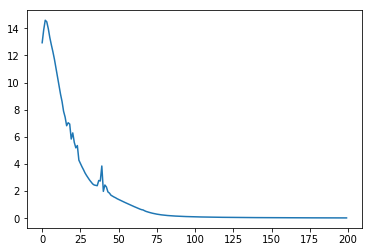

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss_)

In [45]:
def predict(predcit_feature, model_path):
    embedding_size = 128
    unit_num = 128
    dropout_rate = None
    output_size = 5
    batch_size = 1
    seq_length = 10
    lr = 0.001
    
    X = tf.placeholder(tf.float32, shape=[batch_size, seq_length * embedding_size])
    pred = lstm_crf(X)
    saver = tf.train.Saver(tf.global_variables())
    predict_label=[]
    with tf.Session() as sess:
        #参数恢复
        module_file = tf.train.latest_checkpoint(model_path)
        saver.restore(sess, module_file)
        for step in range(len(predcit_feature)-1):
            prob = sess.run(pred, feed_dict={X:predcit_feature[step]})
            predict=prob.reshape((-1)).reshape(-1,5)
            predict_label.append(predict)
    return predict_label

In [47]:
predict_result = predict(mat, "./NER_FOLDER/")

INFO:tensorflow:Restoring parameters from ./NER_FOLDER/lstm_crf-180


In [50]:
for line in predict_result:
    predict_label = onehot_model.decode(line)
    print(predict_label)

[['O' 'B-ORG-A' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
[['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-ORG-A' 'I-ORG-A']]
[['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
[['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
[['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
[['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
[['O' 'B-ORG-O' 'I-ORG-O' 'O' 'O' 'O' 'B-ORG-O' 'O' 'B-ORG-O' 'I-ORG-O']]


D:\ProgramingTools\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\ProgramingTools\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\ProgramingTools\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\ProgramingTools\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning 